##2.a. Multi Label Classification using Ensemble models

In [ ]:
#Importing Necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
!pip install shap
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


from sklearn.preprocessing import LabelEncoder


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Importing the data
store_1 = pd.read_csv("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_01.csv")
store_2 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_02.csv") #The data is formated as excel sheet but stored as csv extension.
store_3 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_03.xlsx")
store_4 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_04.xlsx")
store_5 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_05.xlsx")
store_6 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_06.xlsx")
store_7 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_07.xlsx")
store_8 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_08.xlsx")
store_9 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_09.xlsx")
store_10 = pd.read_excel("/content/drive/MyDrive/CECS551_dataset_01/store_features/store_10.xlsx")

#Importing store type
stores = pd.read_csv("/content/drive/MyDrive/CECS551_dataset_01/stores.csv")


In [ ]:
#changing Store 1 date format to make it consistent with the data
store_1['Date'] = pd.to_datetime(store_1['Date'], format='%m/%d/%Y').dt.strftime('%Y/%m/%d')

#concatinating all the stores together
features = pd.concat([store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10])

# Final dataset contating all the stores' features and store types
stores_data = pd.merge(stores, features[['Store','Date','Unemployment','gas_price','Temperature','CPI','discount_promotional','discount_clearance','discount_damaged_good','discount_competitive']])

#Finding NaN values in Discount columns.
markdowns = ['discount_clearance','discount_promotional','discount_damaged_good', 'discount_competitive']
for column_name in markdowns:
    markdown_frac = features[column_name].isnull().sum() / features[column_name].shape[0]
    print(f"{int(100 * round(markdown_frac, 2))}% of {column_name} values are NaN.")

#Handling missing values
stores_data.fillna(stores_data.mean())



57% of discount_clearance values are NaN.
46% of discount_promotional values are NaN.
50% of discount_damaged_good values are NaN.
47% of discount_competitive values are NaN.


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Store,Type,Size,Date,Unemployment,gas_price,Temperature,CPI,discount_promotional,discount_clearance,discount_damaged_good,discount_competitive
0,1,A,151315,2010/02/05,6.833000,3.360,59.33,223.659114,9667.50,268.29,0.600000,8368.15
1,1,A,151315,2010/02/12,6.833000,3.409,51.65,223.753643,8687.47,1594.87,2.200000,2144.87
2,1,A,151315,2010/02/19,6.833000,3.510,52.39,223.917015,2706.87,3128.74,1.880000,2396.68
3,1,A,151315,2010/02/26,6.833000,3.555,60.12,224.132020,6129.28,1802.84,1823.168202,301.48
4,1,A,151315,2010/03/05,6.833000,3.630,61.65,224.347025,3552.58,601.32,1823.168202,2666.22
...,...,...,...,...,...,...,...,...,...,...,...,...
1815,10,B,126512,2013-06-28 00:00:00,6.783537,3.781,90.28,198.850394,5894.36,102.74,10.500000,5852.61
1816,10,B,126512,2013-07-05 00:00:00,6.783537,3.753,93.54,198.850394,14076.31,1533.74,523.780000,7971.03
1817,10,B,126512,2013-07-12 00:00:00,6.783537,3.737,87.18,198.850394,5894.71,393.58,38.540000,4523.58
1818,10,B,126512,2013-07-19 00:00:00,6.783537,3.823,87.09,198.850394,7816.71,791.21,165.000000,8330.84


In [ ]:
# Enconding the target variable as it is a categorical feature with types A, B and C
target = 'Type'
labelencoder = LabelEncoder()
stores_data['Type'] = labelencoder.fit_transform(stores_data['Type'])

#Selecting target variable
y = stores_data[target]
X = stores_data.drop(columns=[target, "Date","Store"])

# Handling missing values
X = X.fillna(stores_data.mean())
y = y.fillna(y.mode()[0])

#Train test splitting[80/20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


##Recurrent Neural Network

In [ ]:
#imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
#reshaping X_test to make it compatible as an input for the model

X_train = np.asarray(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#Declaring a sequential model
rnn = Sequential()

#Adding an input layer of 45 units with a dropout value of 0.2
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn.add(Dropout(0.2))

#Adding three hidden layers of 45 units with dropout value 0.2
rnn.add(LSTM(units = 45, return_sequences = False))
rnn.add(Dropout(0.2))

#rnn.add(LSTM(units = 45, return_sequences = True))
#rnn.add(Dropout(0.2))

#rnn.add(LSTM(units = 45))
#rnn.add(Dropout(0.2))

#Output layer with one unit
rnn.add(Dense(units = 1, activation='sigmoid'))

In [ ]:
#Compiling the sequential model
rnn.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
#Converting every value in X_train into np.float32 data type
X_train = np.asarray(X_train).astype(np.float32)

In [ ]:
#Fitting the rnn model to the dataset
rnn.fit(X_train, y_train, epochs = 100, batch_size = 128)

Epoch 1/100
12/12 [==============================] - 5s 22ms/step - loss: 0.7044
Epoch 2/100
12/12 [==============================] - 0s 24ms/step - loss: 0.6980
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.6915
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 0.6844
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 0.6742
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.6516
Epoch 7/100
12/12 [==============================] - 0s 21ms/step - loss: 0.6140
Epoch 8/100
12/12 [==============================] - 0s 21ms/step - loss: 0.5843
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 0.5751
Epoch 10/100
12/12 [==============================] - 0s 22ms/step - loss: 0.5702
Epoch 11/100
12/12 [==============================] - 0s 21ms/step - loss: 0.5759
Epoch 12/100
12/12 [==============================] - 0s 20ms/step - loss: 0.5720
Epoch 13/100
12/12 [=====

In [ ]:
#reshaping X_test to make it compatible as an input for the model
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#Predicting the store types
y_pred = rnn.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_pred.reshape(364)

12/12 [==============================] - 1s 4ms/step


array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,

ROC AUC Score: 0.962


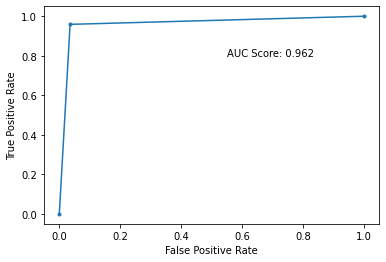

In [ ]:
#ROC Curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculating AUC score
lr_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC Score: %.3f' % (lr_auc))
# calculating values for roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
# plotting the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.55, 0.8, "AUC Score: %.3f" % (lr_auc))
pyplot.show()

In [ ]:
#Calculating Precision-Recall, confusion matrix, F1 score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='micro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(matrix)

NameError: ignored

## ens

In [ ]:
# KNN Classifier

# Define and train classifier
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

# Make prediction
y_test_pred = knn.predict(X_test)

# Calculate Accuracy
knn_test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate F1-score
knn_test_f1 = f1_score(y_test, y_test_pred, average='micro')

print('Model performance for Test set')
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_test_pred, average='micro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_test_pred, average='micro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_test_pred, average='micro')
print('F1 score: %f' % f1)

Model performance for Test set
Accuracy: 0.994505
Precision: 0.994505
Recall: 0.994505
F1 score: 0.994505


Accuracy: 0.994505
Precision: 0.994505
Recall: 0.994505
F1 score: 0.994505
Confusion Matrix:
[[169   0]
 [  2 193]]
ROC AUC Score: 0.995


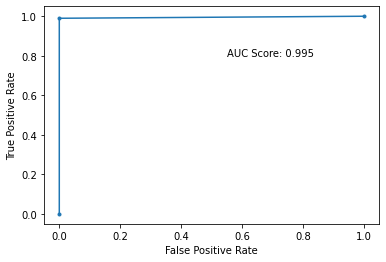

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

knn_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % knn_test_accuracy)
knn_test_precision = precision_score(y_test, y_test_pred, average='micro')
print('Precision: %f' % knn_test_precision)
knn_test_recall = recall_score(y_test, y_test_pred, average='micro')
print('Recall: %f' % knn_test_recall)
knn_test_f1 = f1_score(y_test, y_test_pred, average='micro')
print('F1 score: %f' % knn_test_f1)
knn_test_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(knn_test_matrix)

# calculating AUC score
knn_test_lr_auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC Score: %.3f' % (knn_test_lr_auc))
# calculating values for roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_pred)
# plotting the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.55, 0.8, "AUC Score: %.3f" % (knn_test_lr_auc))
pyplot.show()

Model performance for Test set
Accuracy: 0.771978
Precision: 0.718750
Recall: 0.943590
F1 score: 0.815965
Confusion Matrix:
[[ 97  72]
 [ 11 184]]
ROC AUC Score: 0.759


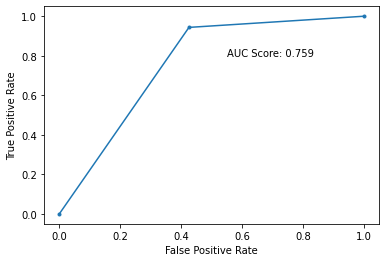

In [ ]:
# Multi Layer Perceptron classifier

mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)

# Make predictions
y_test_pred = mlp.predict(X_test)

# Test set performance
mlp_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
mlp_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score


print('Model performance for Test set')
mlp_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % mlp_test_accuracy)
mlp_test_precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % mlp_test_precision)
mlp_test_recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % mlp_test_recall)
mlp_test_f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % mlp_test_f1)
mlp_test_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(mlp_test_matrix)

# calculating AUC score
mlp_test_lr_auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC Score: %.3f' % (mlp_test_lr_auc))
# calculating values for roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_pred)
# plotting the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.55, 0.8, "AUC Score: %.3f" % (mlp_test_lr_auc))
pyplot.show()

Model performance for Test set
Accuracy: 0.692308
Precision: 1.000000
Recall: 0.425641
F1 score: 0.597122
Confusion Matrix:
[[169   0]
 [112  83]]
ROC AUC Score: 0.713


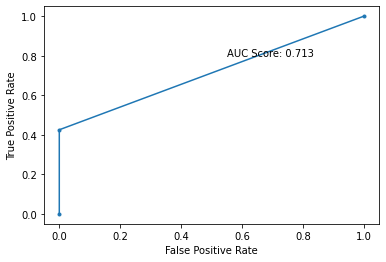

In [ ]:
#Support Vector classifier

svc = SVC(gamma=1, C=1)
svc.fit(X_train, y_train)

# Make predictions
y_test_pred = svc.predict(X_test)

# Test set performance
svc_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
svc_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Test set')
svc_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % svc_test_accuracy)
svc_test_precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % svc_test_precision)
svc_test_recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % svc_test_recall)
svc_test_f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % svc_test_f1)
svc_test_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(svc_test_matrix)

# calculating AUC score
svc_test_lr_auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC Score: %.3f' % (svc_test_lr_auc))
# calculating values for roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_pred)
# plotting the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.55, 0.8, "AUC Score: %.3f" % (svc_test_lr_auc))
pyplot.show()

In [ ]:
# Averaging ensemble method

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

pred_1 = knn.predict(X_test)
pred_2 = svc.predict(X_test)
pred_3 = mlp.predict(X_test)

# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0

# printing the mean squared error between real value and predicted value
print(mean_squared_error(y_test, pred_final))



0.06868131868131869


In [ ]:
# Weighted average ensemble method

pred_1 = knn.predict(X_test)
pred_2 = svc.predict(X_test)
pred_3 = mlp.predict(X_test)

# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1*0.3+pred_2*0.3+pred_3*0.4)

# printing the mean squared error between real value and predicted value
print(mean_squared_error(y_test, pred_final))

0.07357142857142858


In [ ]:
# Voting ensemble method

from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('knn', knn), ('svm_rbf', svc), ('mlp', svc)], voting='hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)


0.6923076923076923

Model performance for Test set
Accuracy: 0.994505
Precision: 1.000000
Recall: 0.989744
F1 score: 0.994845
Confusion Matrix:
[[169   0]
 [  2 193]]
ROC AUC Score: 0.995


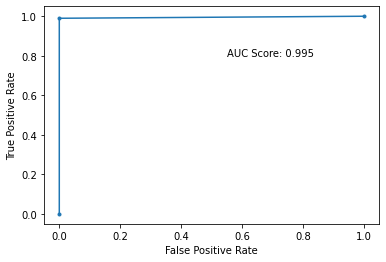

In [ ]:
#Stacking the classifiers

import xgboost as xgb

# Define estimators
estimator_list = [
    ('knn',knn),
    ('svc',svc),
    ('mlp',mlp) ]


# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make prediction
y_test_pred = stack_model.predict(X_test)

# Test set model performance
print('Model performance for Test set')
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % stack_model_test_accuracy)
stack_model_test_precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % stack_model_test_precision)
stack_model_test_recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % stack_model_test_recall)
stack_model_test_f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % stack_model_test_f1)
stack_model_test_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(stack_model_test_matrix)

# calculating AUC score
stack_model_test_lr_auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC Score: %.3f' % (stack_model_test_lr_auc))
# calculating values for roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_test_pred)
# plotting the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.55, 0.8, "AUC Score: %.3f" % (stack_model_test_lr_auc))
pyplot.show()

In [ ]:
acc_test_list = {'knn':knn_test_accuracy,
'svm_rbf': svc_test_accuracy,
'mlp': mlp_test_accuracy,
'stack': stack_model_test_accuracy}


f1_test_list = {'knn':knn_test_f1,
'svm_rbf': svc_test_f1,
'mlp': mlp_test_f1,
'stack': stack_model_test_f1}

precision_test_list = {'knn':knn_test_precision,
'svm_rbf': svc_test_precision,
'mlp': mlp_test_precision,
'stack': stack_model_test_precision}

recall_test_list = {'knn':knn_test_recall,
'svm_rbf': svc_test_recall,
'mlp': mlp_test_recall,
'stack': stack_model_test_recall}

roc_test_list = {'knn':knn_test_lr_auc,
'svm_rbf': svc_test_lr_auc,
'mlp': mlp_test_lr_auc,
'stack': stack_model_test_lr_auc}

In [ ]:
import pandas as pd

acc_df = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy'])
f1_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1'])
precision_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['Precision'])
recall_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['Recall'])
roc_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['ROC AUC Score'])
performance_metrics = pd.concat([acc_df, f1_df, precision_df, recall_df, roc_df], axis=1)
performance_metrics

,Accuracy,F1,Precision,Recall,ROC AUC Score
knn,0.994505,0.994505,0.994505,0.994505,0.994505
svm_rbf,0.692308,0.597122,0.597122,0.597122,0.597122
mlp,0.771978,0.815965,0.815965,0.815965,0.815965
stack,0.994505,0.994845,0.994845,0.994845,0.994845
